In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta

In [3]:
dataset = xr.open_dataset("tco300_omimls_oct2004_to_dec2024_1by1.nc")

OMI/MLS Ground-to-300hPa Column Ozone for TOARII

So now it is time for some data cleaning, there should not be negative values in the data

In [4]:
ozone_data = dataset["TropoO3"]
cleaned_ozone_dataset = ozone_data.where(ozone_data >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset

In [5]:
dataset

<xarray.Dataset> Size: 63MB
Dimensions:  (months: 243, y_elements: 180, x_elements: 360)
Dimensions without coordinates: months, y_elements, x_elements
Data variables:
    TropoO3  (months, y_elements, x_elements) float32 63MB nan nan ... nan nan
Attributes:
    Title:    OMI/MLS Ground-to-300hPa Column Ozone for TOARII, etc.

Try to visualize this cleaned data now for arbitrary month

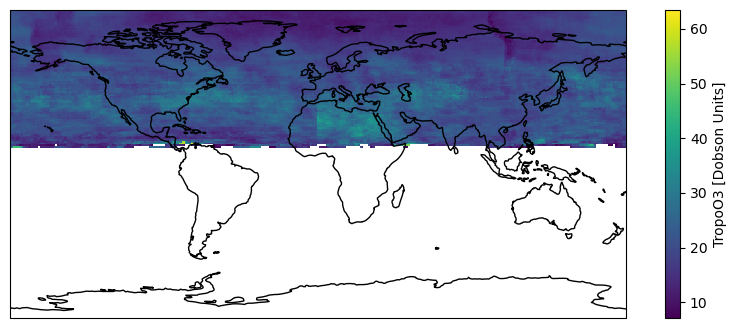

In [13]:
ozone_month = dataset["TropoO3"].isel(months=150)

fig = plt.figure(figsize=(10,4))
#ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ozone_month.plot(ax=ax, cmap='viridis', transform=ccrs.PlateCarree())

plt.show()

In [7]:
times = pd.date_range(start='2004-10-01', periods=243, freq='MS')

ozone_climatology = dataset.groupby('TropoO3').mean(dim='time')

january_climatology = ozone_climatology.sel(month=7)
january_climatology.plot()

ValueError: cannot reduce over dimensions time.